### 목적
- 10개의 다른 단어를 인식하는 음성 인식 네트워크 구성

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 13
tf.random.set_seed(seed)
np.random.seed(seed)

### 데이터 다운로드

In [2]:
# data_dir = pathlib.Path('C:/Users/seonwook/Documents/ds_study/data/mini_speech_commands')
# url = 'http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip'
# if not data_dir.exists():
#     tf.keras.utils.get_file(
#         'mini_speech_comands.zip',
#         origin=url,
#         extract=True,
#         cache_dir='.', cache_subdir='data'
#     )

- Speech Commands Data set:
    - 원 데이터는 30개의 단어에 대해 각각 다른 사람의 105,000개 이상의 wav파일로 구성되어 있음

### 명령 종류

In [3]:
data_dir = pathlib.Path('C:/Users/seonwook/Documents/DL/data/mini_speech_commands')
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commans:', commands)

Commans: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


### 데이터 목록 추출 및 shuffle

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'C:\\Users\\seonwook\\Documents\\DL\\data\\mini_speech_commands\\down\\9a43b64b_nohash_0.wav', shape=(), dtype=string)


### train, val, test

In [6]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training get size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training get size 6400
Validation set size 800
Test set size 800


### wav파일 변환

In [7]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

- tf.audio.decode_wav는 샘플 음성 신호를 -1과 1사이의 값으로 정규화함

### 레이블 얻는 함수

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

In [10]:
# 한번에
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

### 데이터셋으로 변환

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

### 오디오를 파형으로 확인해보기

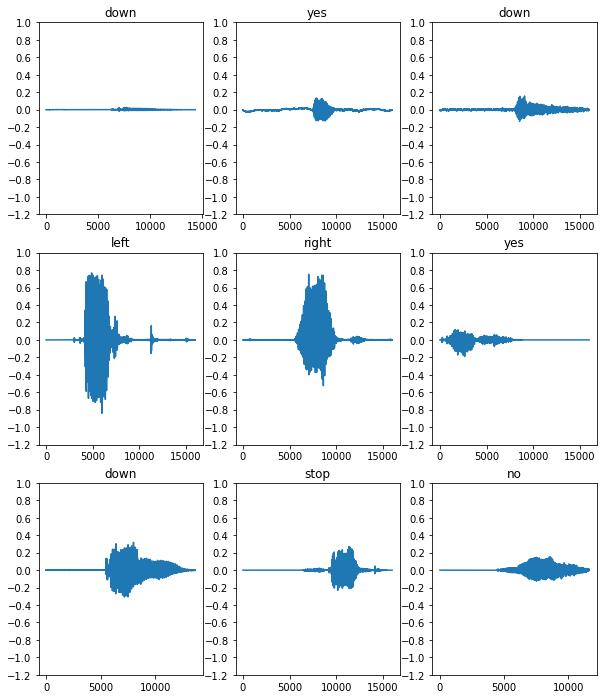

In [12]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

### 스펙트럼 얻기

In [15]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the
    # same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128
    )

    spectrogram = tf.abs(spectrogram)

    return spectrogram

- 음성 파형(시간)을 주파수로 변환

### 스펙트럼 변환 shape과 본 음성 확인

In [16]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (14336,)
Spectrogram shape: (124, 129)
Audio playback


### 스펙트럼 시각화

C:\Users\seonwook\AppData\Local\Temp/ipykernel_137844/3532957000.py:2: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


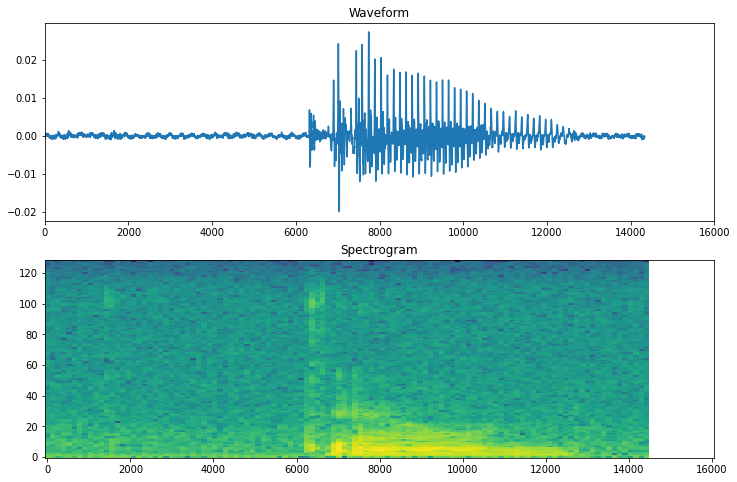

In [17]:
def plot_spectrogram(spectrogram, ax):
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

### 스펙트럼 결과와 라벨 정리

In [18]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [19]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE
)

### 시각화

C:\Users\seonwook\AppData\Local\Temp/ipykernel_137844/3532957000.py:2: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


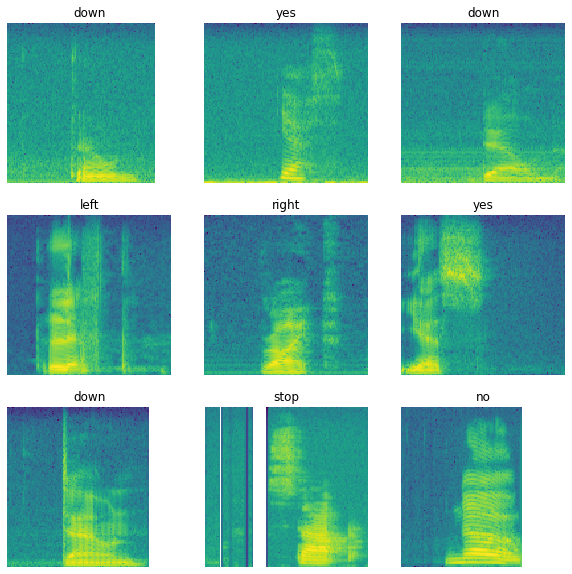

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

### 데이터셋 분할

In [21]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE
    )
    return output_ds

In [22]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

### 배치사이즈 지정

In [23]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

### Simple CNN

In [26]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         

### 모델 컴파일

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### 학습

In [28]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
100/100 [==============================] - 12s 112ms/step - loss: 1.7319 - accuracy: 0.3681 - val_loss: 1.3264 - val_accuracy: 0.5800
Epoch 2/10
100/100 [==============================] - 11s 106ms/step - loss: 1.1811 - accuracy: 0.5823 - val_loss: 0.9025 - val_accuracy: 0.7237
Epoch 3/10
100/100 [==============================] - 11s 109ms/step - loss: 0.8937 - accuracy: 0.6792 - val_loss: 0.7258 - val_accuracy: 0.7713
Epoch 4/10
100/100 [==============================] - 12s 116ms/step - loss: 0.7505 - accuracy: 0.7244 - val_loss: 0.6260 - val_accuracy: 0.8025
Epoch 5/10
100/100 [==============================] - 12s 121ms/step - loss: 0.6374 - accuracy: 0.7672 - val_loss: 0.5774 - val_accuracy: 0.8112
Epoch 6/10
100/100 [==============================] - 11s 111ms/step - loss: 0.5536 - accuracy: 0.8014 - val_loss: 0.5165 - val_accuracy: 0.8450
Epoch 7/10
100/100 [==============================] - 11s 108ms/step - loss: 0.4778 - accuracy: 0.8295 - val_loss: 0.4985 - val_ac

### 결과

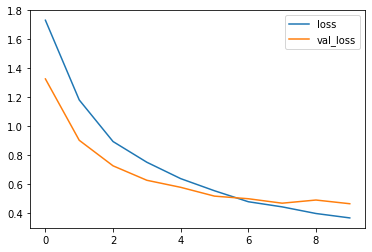

In [29]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

### test_data

In [30]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [31]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 83%


### confusion matrix

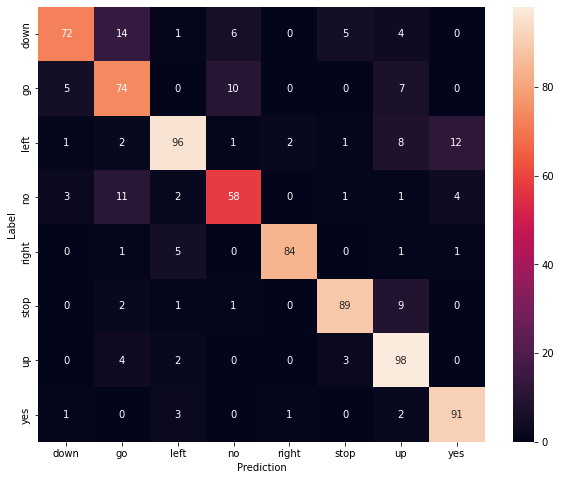

In [32]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### 샘플 예측

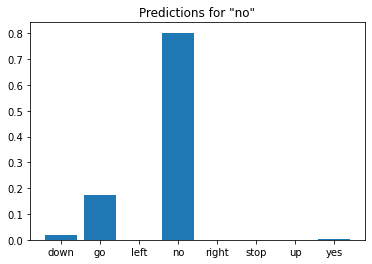

In [38]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()